# Twitter Sentiment Analysis - POC
---

## 7. Quickly train various models

**Current State**: I've trained three baseline models with little tweaking, fine-tuned a single decision tree, and trained a few random forests on a Bag-of-Word subset of $m\approx250k, n=50k$ of the training data, using cross validation, and got the following mean accuracy scores:

- Logistic Regression: $78.8\%$
- Naive Bayes: $77.6\%$ 
- SGD (log loss): $77.1\%$ 
- Random Forests: $75.0\%$
- Decision Tree: $69.0\%$

**This Notebook**: since the previous notebook's random forests were built on few instances, I'm choosing a couple of the best ones to train on the entire training data (for th POC) and plotting some learning curves.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score

### Load $m\approx250k$, $n=50k$ training subset

In [2]:
# processed dir
proc_dir = os.path.join("..","data","3_processed","sentiment140")
X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'rb') as f:
    y_array = np.load(f)

In [3]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_transformed, 
                                                      y_array, 
                                                      test_size=0.2, 
                                                      random_state=42)

### Define functions

These are helper functions for getting data for plotting the learning curves.

In [48]:
def get_learning_data(clf):
    xs, train_acc, valid_acc = [], [], []
    for m_instances in range(1004, 201174, 22241):
        rf_clf.fit(X_train[:m_instances], y_train[:m_instances])
        y_train_predict = rf_clf.predict(X_train[:m_instances])
        y_valid_predict = rf_clf.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m_instances], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m_instances)) 
    return xs, train_acc, valid_acc

In [49]:
def plot_learning_curve(xs, train_acc, valid_acc):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, X_train.shape[0], 0.4, 0.8])
    plt.plot(xs, train_acc, 'r--', linewidth=.8, label="train accuracy")
    plt.plot(xs, valid_acc, 'b--', linewidth=.8, label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation"]), fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

### Random Forest 1

This is a very big 10,000-tree forest which uses `max_leaf_nodes=99` as its main constraining factor.

Alas, `warm_start=True` is used to increase n_estimators, not n_samples, so it can't be used for learning curves.

In [42]:
rf_clf1 = RandomForestClassifier(n_estimators=10000, # the second DIY forest params
                                max_samples=None, # 2000 was the max then, got 75% accuracy
                                max_features="sqrt", 
                                max_leaf_nodes=99, 
                                random_state=42,
                                n_jobs=-1, 
                                verbose=0)

In [44]:
xs1, train_acc1, valid_acc1 = get_learning_data(rf_clf1)

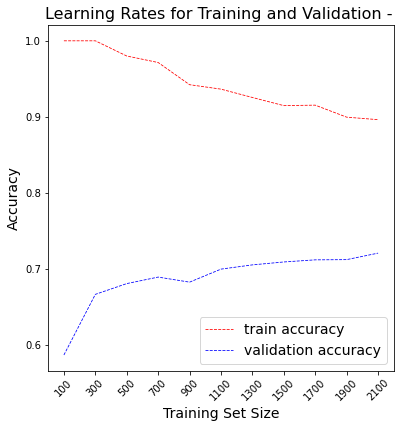

In [26]:
plot_learning_curve(xs1, train_acc1, valid_acc1)

In [37]:
print(f'Min training accuracy: {min(train_acc1):0.4f}')
print(f'Max validation accuracy: {max(valid_acc1):0.4f}')

Min training accuracy: 0.8962
Max validation accuracy: 0.7205


### Random Forest 2

This is a 1,000-tree forest that uses `max_features=200` as its limiting factor.

In [38]:
rf_clf2 = RandomForestClassifier(n_estimators=1000, # the grid search params
                                 max_samples=None, # 8000 was the max then, got 75% accuracy as well
                                 max_features=200, 
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [ ]:
xs2, train_acc2, valid_acc2 = get_learning_data(rf_clf2)

In [ ]:
plot_learning_curve(xs2, train_acc2, valid_acc2)

In [ ]:
print(f'Min training accuracy: {min(train_acc2):0.4f}')
print(f'Max validation accuracy: {max(valid_acc2):0.4f}')

### Random Forest 3

This is a small forest of 300 trees which uses `max_features="sqrt"` as a limiting factor.

In [39]:
rf_clf3 = RandomForestClassifier(n_estimators=300,
                                 max_samples=None, 
                                 max_features="sqrt",
                                 max_depth=None,
                                 random_state=42,
                                 n_jobs=-1, 
                                 verbose=0)

In [ ]:
xs3, train_acc3, valid_acc3 = get_learning_data(rf_clf3)

In [ ]:
plot_learning_curve(xs3, train_acc3, valid_acc3)

In [42]:
print(f'Min training accuracy: {min(train_acc3):0.4f}')
print(f'Max validation accuracy: {max(valid_acc3):0.4f}')

0.7839

---